In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import os

def calculate_distance_from_point_to_station(row, given_point_coord):
    station_coord = (row['LATITUDE:'], row['LONGITUDE:'])
    # given_point_coord = (-15.789343, -47.925756)
    return geodesic(station_coord, given_point_coord).kilometers

df_all_stations = pd.read_csv("../data/all_stations.csv", decimal=",", sep=";")

# given_point_coord = (-16.012222, -47.557417)
# df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, given_point_coord), axis=1) 

# df_nearest_stations = df_all_stations[df_all_stations["Distancia"] < 50]

# df_point_stations = df_all_stations[df_all_stations["Distancia"] < 1]

# Estaçoes do DF
codes_of_stations_to_analyze = ["A001", "A042", "A045", "A046", "A047"]

stations_data = []

# stations_files_to_read = set()

for code in codes_of_stations_to_analyze:
    station_info = df_all_stations[df_all_stations["CODIGO (WMO):"] == code]

    latitude = station_info["LATITUDE:"].iloc[0]
    longitude = station_info["LONGITUDE:"].iloc[0]

    station_coord = (latitude, longitude)

    df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, station_coord), axis=1) 
    df_nearest_stations = df_all_stations[(df_all_stations["Distancia"] != 0) & (df_all_stations["Distancia"] < 50)]

    station_data = { 
        "code": code,
        "station_info": station_info,
        "nearest_stations_info": df_nearest_stations,
    }

    # df_nearest_stations["Arquivo"].apply(lambda x: stations_files_to_read.add(x))
    # stations_files_to_read.add(station_info["Arquivo"].iloc[0])
    stations_data.append(station_data)

print(stations_data)
# print(stations_files_to_read)

[{'code': 'A001', 'station_info':     REGI?O: UF:  ESTAC?O: CODIGO (WMO):   LATITUDE:  LONGITUDE: ALTITUDE:  \
442      CO  DF  BRASILIA          A001  -15.789343  -47.925756   1160.96   

                                               Arquivo  
442  INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2...  , 'nearest_stations_info':     REGI?O: UF:            ESTAC?O: CODIGO (WMO):     LATITUDE:    LONGITUDE:  \
2        CO  DF  PARANOA (COOPA-DF)          A047    -16.012222    -47.557417   
141      CO  DF          BRAZLANDIA          A042  -15.59972221   -48.1311111   
233      CO  DF     AGUAS EMENDADAS          A045    -15.596491    -47.625801   
239      CO  DF   GAMA (PONTE ALTA)          A046  -15.93527777  -48.13749999   

    ALTITUDE:                                            Arquivo  Distancia  
2      1043.0  INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2019...  46.520207  
141    1143.0  INMET_CO_DF_A042_BRAZLANDIA_01-01-2019_A_31-12...  30.411300  
233   1030.36  INMET_CO_DF_A045

In [ ]:
# yeardirectoryfilename = []
# df_nearest_stations_weather_data = []

# stations_dataframes = {
    
# }

def read_station_data(filename, start_year, end_year):
    station_data = []

    for year in range(start_year, end_year + 1):
        file = f'../data/cleaned_data/{year}_cleaned/{filename.replace("2019", str(year))}'
        df_weather_data = pd.read_csv(file, decimal=".", sep=";")
        station_data.append(df_weather_data)

    return pd.concat(station_data, ignore_index= True)

for station in stations_data:
    station_info = station["station_info"]
    station_file_name = station_info["Arquivo"].iloc[0]

    station["station_data"] = read_station_data(station_file_name, 2019, 2023)

    nearest_stations_data = []
    for index, nearest_station in station["nearest_stations_info"].iterrows():
        nearest_station_file_name = nearest_station["Arquivo"]
        nearest_station_data = read_station_data(nearest_station_file_name, 2019, 2023)

        nearest_stations_data.append(nearest_station_data)

    nearest_stations_data_compilation = pd.concat(nearest_stations_data, ignore_index= True)

    station["nearest_stations_data"] = nearest_stations_data_compilation

MSE: 2.9086876340296928
RMSE: 1.7054875062660801
sMAPE: 5.920299648493218


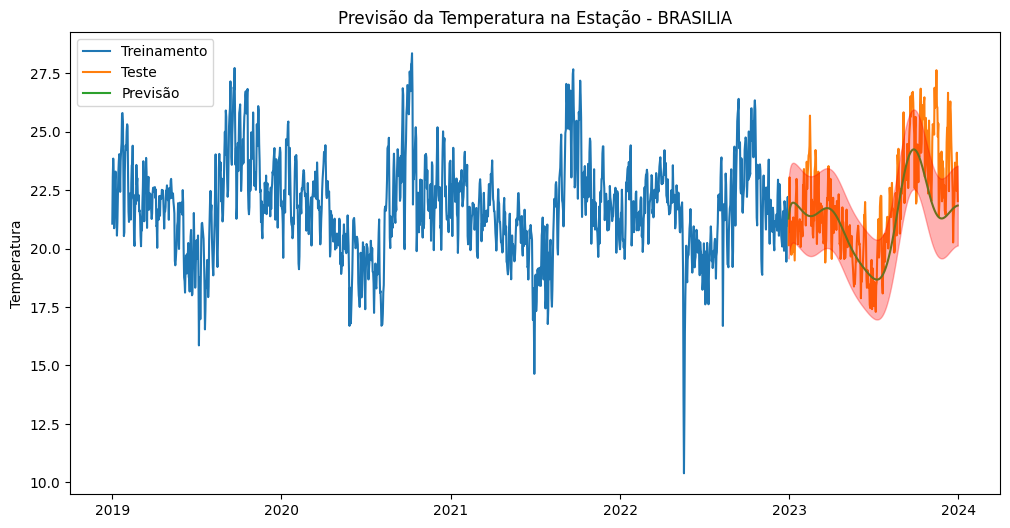

MSE: 4.402009393484561
RMSE: 2.0980966120473483
sMAPE: 7.522744548062424


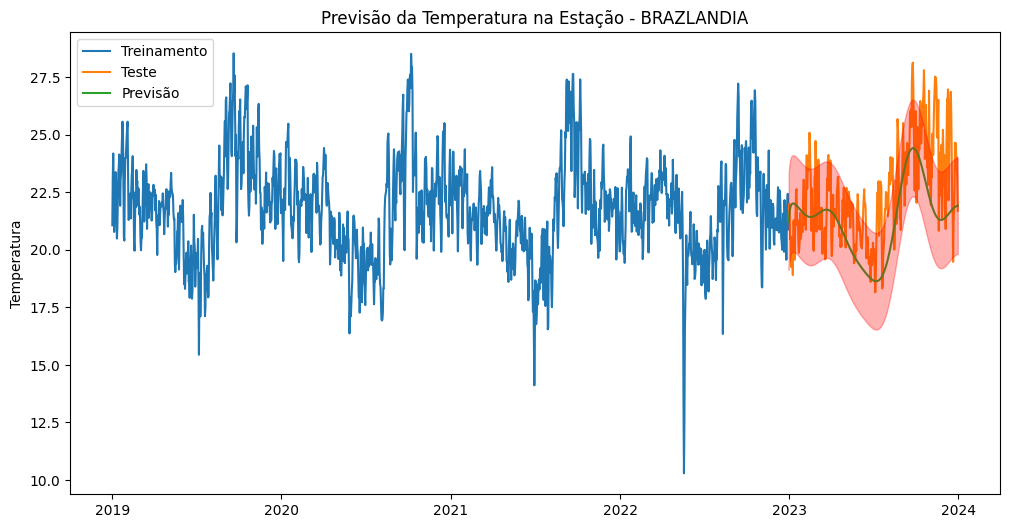

MSE: 3.5882551720252915
RMSE: 1.8942690336975083
sMAPE: 6.737415793207736


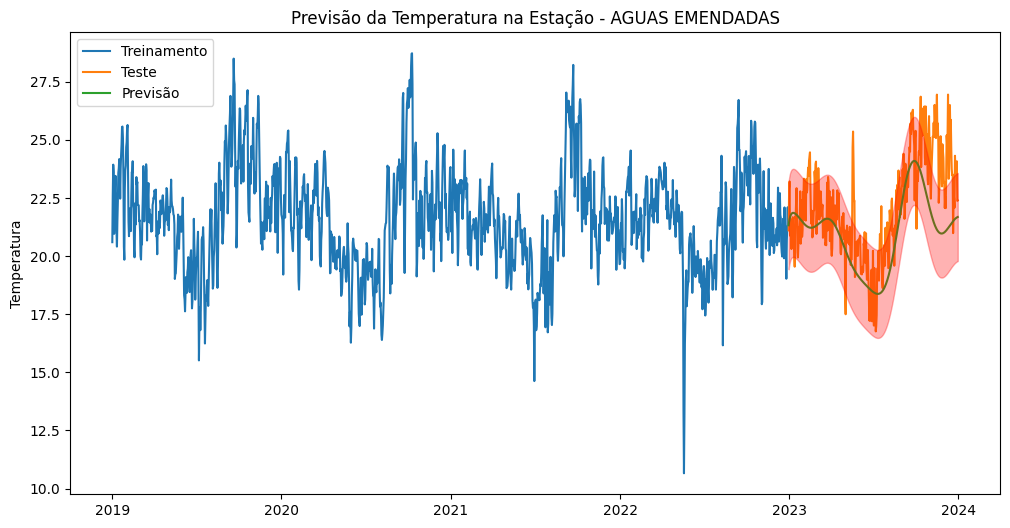

MSE: 4.058455065011205
RMSE: 2.0145607623030894
sMAPE: 6.820126029176846


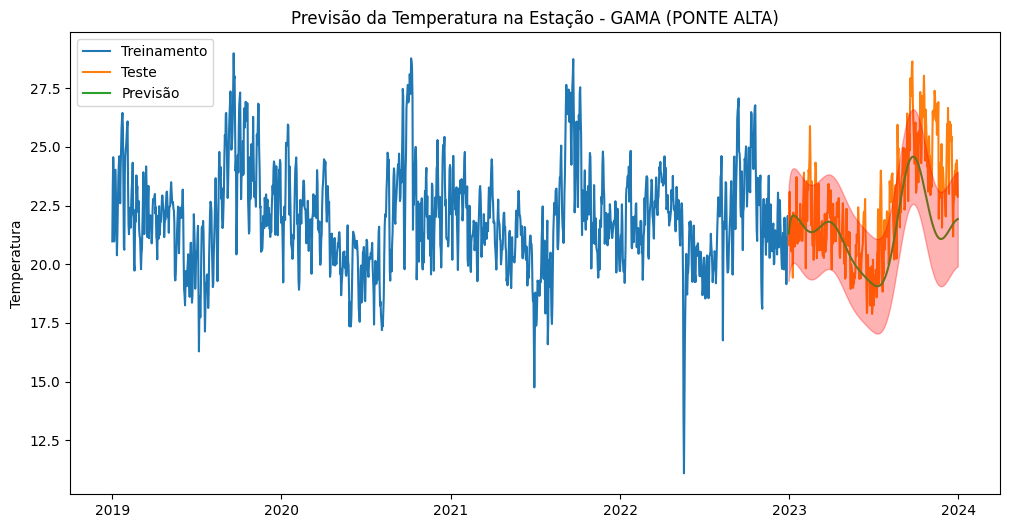

MSE: 5.51524141181241
RMSE: 2.34845511173035
sMAPE: 8.326483312013542


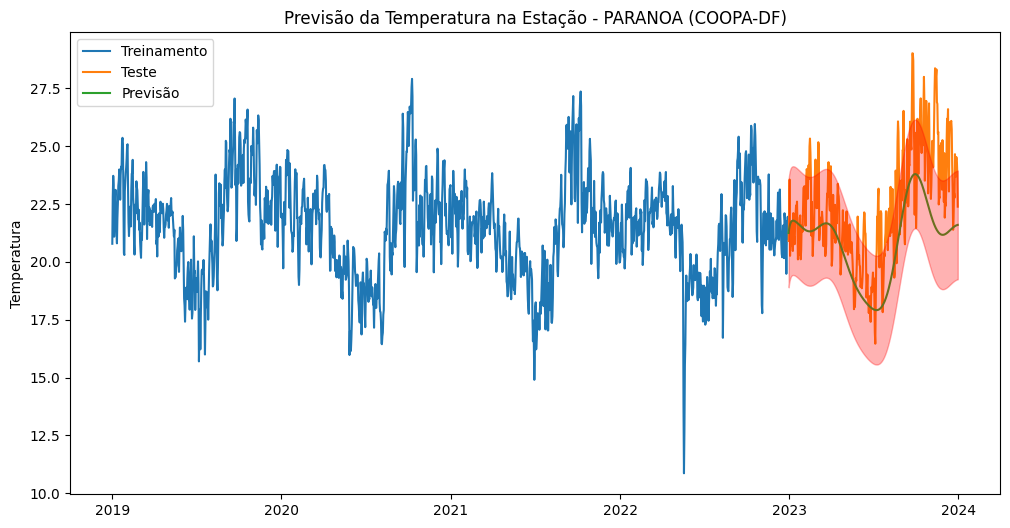

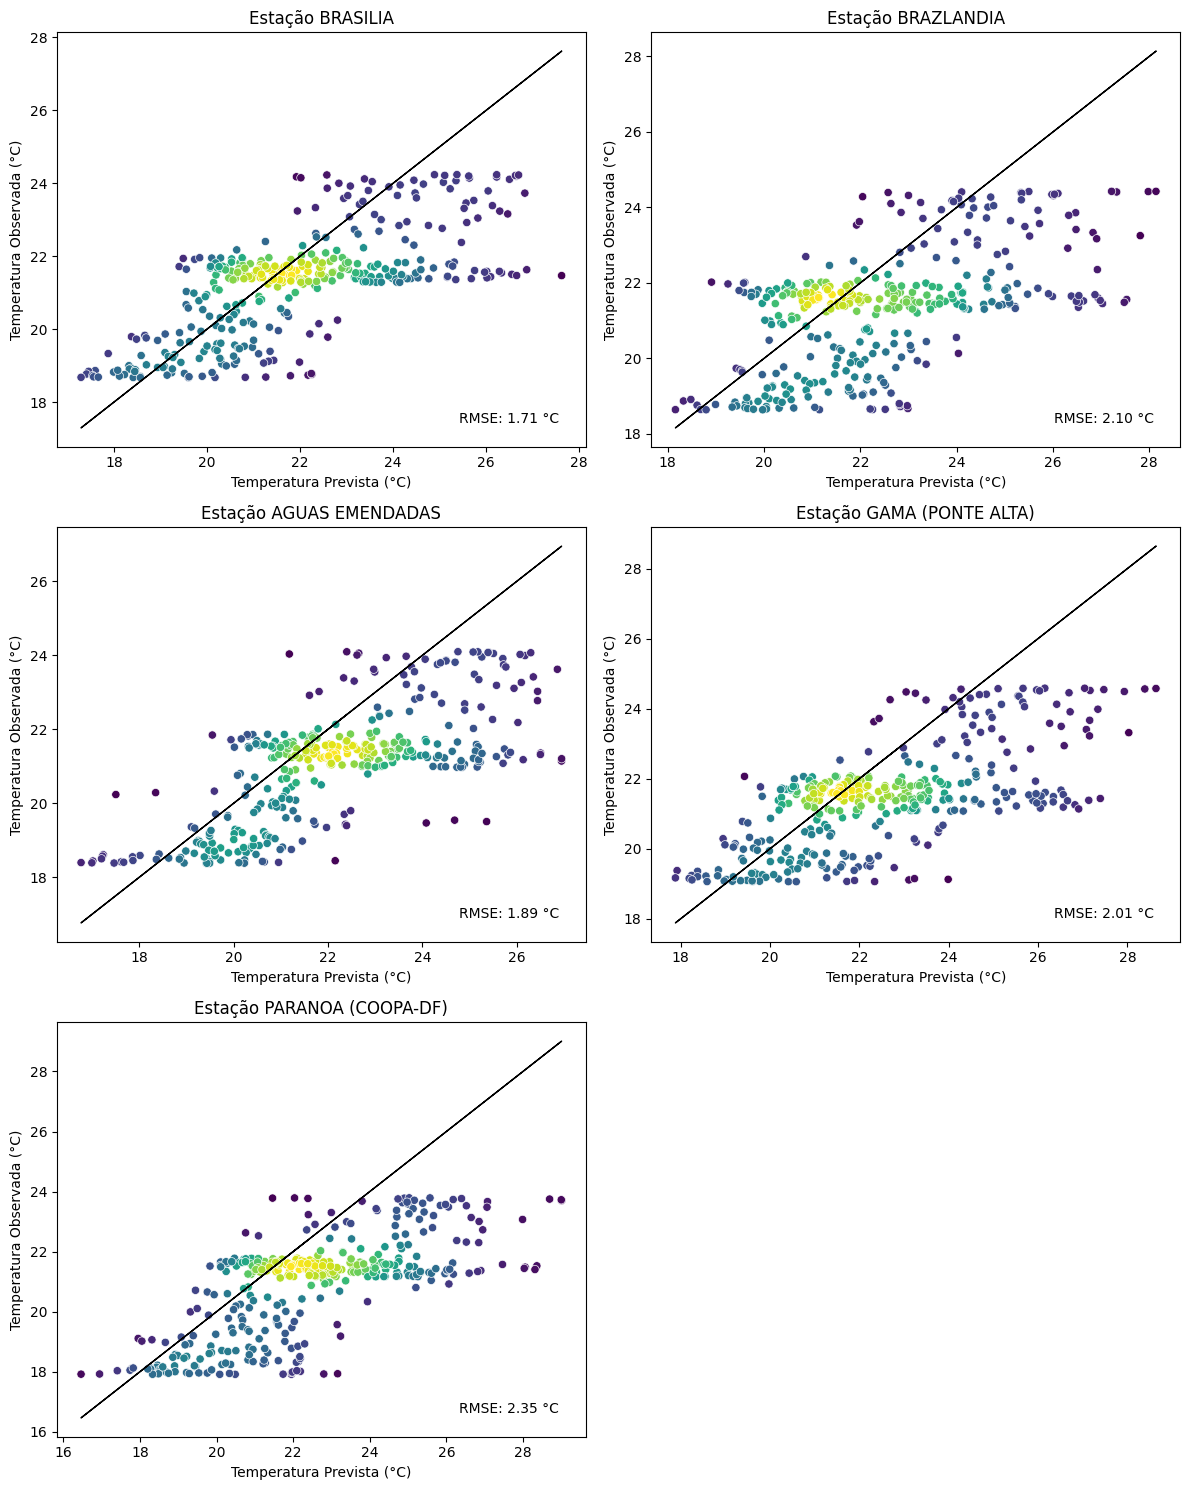

In [45]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns

# df_nearest_stations_weather_data = []

# for filename in df_nearest_stations['Arquivo']: 
#     df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename}', decimal=".", sep=";")
#     df_nearest_stations_weather_data.append(df_weather_data)

# df_compilation_of_nearest_stations_weather_data = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

def clean_data(dataframe):
    df_cleaned = dataframe.drop(columns=['Hora UTC'])
    df_cleaned['Data'] = pd.to_datetime(df_cleaned['Data'])

    df_sorted = df_cleaned.sort_values(by='Data', ascending=True)
    df_sorted.set_index('Data', inplace=True)
    df_avarage_temperature_by_day = df_sorted.resample("D").mean()
    df_not_null_values_day = df_avarage_temperature_by_day.ffill()

    return df_not_null_values_day

def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


def get_forecast_test_graph(df_test, forecast, forecast_parameter, ax):
    import numpy as np
    from scipy import stats
    from sklearn.metrics import mean_squared_error
    import seaborn as sns

    values = np.vstack([df_test[forecast_parameter], forecast])
    kernel = stats.gaussian_kde(values)(values)

    # Scatterplot com seaborn no eixo fornecido
    sns.scatterplot(
        x=df_test[forecast_parameter],
        y=forecast,
        hue=kernel,
        palette="viridis",
        ax=ax,
        legend=False
    )

    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5

    # Linha de referência x=y
    ax.plot(df_test[forecast_parameter], df_test[forecast_parameter], color='black', linewidth=1.0)

    # Texto RMSE
    ax.text(0.95, 0.05, f'RMSE: {rmse:.2f} °C', ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

    ax.set_ylabel('Temperatura Observada (°C)')
    ax.set_xlabel('Temperatura Prevista (°C)')

def get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name):
    n_graphs = len(df_tests)
    n_cols = 2
    n_rows = (n_graphs + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    for i in range(n_graphs):
        get_forecast_test_graph(df_tests[i], forecasts[i], forecast_parameter, ax=axes[i])
        axes[i].set_title(f'Estação {stations_name[i]}')

    # Remove os eixos extras se n_graphs for ímpar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def arima_forecast_with_fourier_terms(df_training, df_test, forecast_parameter, title):
    n = len(df_training[forecast_parameter])  # Number of data points
    t = np.arange(n)
    seasonality = 365  

    num_fourier_terms = 4
    fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

    # Fit the ARIMA model using arima with Fourier terms as exogenous variables
    model = ARIMA(df_training[forecast_parameter],exog=fourier_terms[:n], order=(1,0,0), trend='ct')
    model_fit = model.fit()

    # Forecast future values with the fitted model
    forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test)), seasonality, num_fourier_terms)

    # Get the forecast for the future steps with exogenous variables
    forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

    # Fazer previsões
    forecast = model_fit.forecast(steps=len(df_test), exog=forecast_df)

    # Visualização das previsões
    plt.figure(figsize=(12,6))
    plt.plot(df_training.index, df_training[forecast_parameter], label='Treinamento')
    plt.plot(df_test.index, df_test[forecast_parameter], label='Teste')
    plt.plot(df_test.index, forecast, label='Previsão')
    plt.ylabel('Temperatura')
    plt.legend(loc='upper left')

    # Cálculo erro quadrático
    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5
    smape_value = smape(df_test[forecast_parameter], forecast)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'sMAPE: {smape_value}')
    plt.fill_between(df_test.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

    plt.title(title)

    plt.show()

    return forecast

forecasts = []
df_tests = []
stations_name = []
forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
for station in stations_data:
    cleaned_station_data = clean_data(station["station_data"])
    cleaned_nearest_stations_data = clean_data(station["nearest_stations_data"])


    # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
    training_data_length = int(len(cleaned_nearest_stations_data) * 0.8)
    df_training = cleaned_nearest_stations_data[:training_data_length]
    df_test = cleaned_station_data[training_data_length:]

    station_name = station["station_info"]["ESTAC?O:"].iloc[0]
    forecast = arima_forecast_with_fourier_terms(df_training, df_test, forecast_parameter, f'Previsão da Temperatura na Estação - {station_name}')
    # df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

    forecasts.append(forecast)
    df_tests.append(df_test)
    stations_name.append(station_name)

get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name)

# df_cleaned = df_compilation_of_nearest_stations_weather_data.drop(columns=['Hora UTC'])

# df_cleaned['Data'] = pd.to_datetime(df_cleaned['Data'])

# df_sorted = df_cleaned.sort_values(by='Data', ascending=True)

# df_sorted.info()

# forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

# # print(df_notimecollumn.info())
# # print(df_notimecollumn.info())
# #print(df_notimecollumn.groupby(['Data'], as_index= True).mean())

# print(df_sorted.info())

# #Converte Data
# #df_notimecollumn['Data']=pd.to_datetime(df_notimecollumn['Data'])
# df_sorted.set_index('Data', inplace=True)
# df_avarage_temperature_by_day = df_sorted.resample("D").mean()
# df_avarage_temperature_by_month = df_sorted.resample("M").mean()


# # Verificar se há valores nulos
# print(df_avarage_temperature_by_day.isnull().sum())

# # Tratar valores nulos
# df_not_null_values_day = df_avarage_temperature_by_day.ffill()
# df_not_null_values_month = df_avarage_temperature_by_month.ffill()

# Divisão dos dados em treinamento (80%) e teste (20%)- DAILY
# df_splited_data = int(len(df_not_null_values_day) * 0.8)
# df_training, df_test = df_not_null_values_day[:df_splited_data], df_not_null_values_day[df_splited_data:]  

# # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
# df_splited_data_month = int(len(df_not_null_values_month) * 0.8)
# df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# df_nearest_stations_weather_data = []

# for filename in df_nearest_stations['Arquivo']: 
#     df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename}', decimal=".", sep=";")
#     df_nearest_stations_weather_data.append(df_weather_data)

# df_compilation_of_nearest_stations_weather_data = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

# for filename in df_point_stations['INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2019.CSV']:
filename = "INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2019.CSV"
yeardirectoryfilename.append(filename)

df_weather_data = pd.read_csv(f'../data/cleaned_data/2019_cleaned/{filename}', decimal=".", sep=";")
df_nearest_stations_weather_data.append(df_weather_data)

df_weather_data = pd.read_csv(f'../data/cleaned_data/2020_cleaned/{filename.replace("2019", "2020")}', decimal=".", sep=";")
df_nearest_stations_weather_data.append(df_weather_data)

df_weather_data = pd.read_csv(f'../data/cleaned_data/2021_cleaned/{filename.replace("2019", "2021")}', decimal=".", sep=";")
df_nearest_stations_weather_data.append(df_weather_data)

df_weather_data = pd.read_csv(f'../data/cleaned_data/2022_cleaned/{filename.replace("2019", "2022")}', decimal=".", sep=";")
df_nearest_stations_weather_data.append(df_weather_data)

df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename.replace("2019", "2023")}', decimal=".", sep=";")
df_nearest_stations_weather_data.append(df_weather_data)

df_compilation_of_nearest_stations_weather_data_point = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

df_cleaned_point_station = df_compilation_of_nearest_stations_weather_data_point.drop(columns=['Hora UTC'])

df_cleaned_point_station['Data'] = pd.to_datetime(df_cleaned_point_station['Data'])

df_sorted_point_station = df_cleaned_point_station.sort_values(by='Data', ascending=True)

df_sorted_point_station.info()

forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

# print(df_notimecollumn.info())
# print(df_notimecollumn.info())
#print(df_notimecollumn.groupby(['Data'], as_index= True).mean())

print(df_sorted_point_station.info())

#Converte Data
#df_notimecollumn['Data']=pd.to_datetime(df_notimecollumn['Data'])
df_sorted_point_station.set_index('Data', inplace=True)
df_avarage_temperature_by_day_point_data = df_sorted_point_station.resample("D").mean()

# Verificar se há valores nulos
print(df_avarage_temperature_by_day_point_data.isnull().sum())

# Tratar valores nulos
df_not_null_values_day_point_data = df_avarage_temperature_by_day_point_data.ffill()

# Divisão dos dados em treinamento (80%) e teste (20%)- DAILY
df_splited_data_point_data = int(len(df_not_null_values_day_point_data) * 0.8)
df_training_point_data, df_test_point_data = df_not_null_values_day_point_data[:df_splited_data], df_not_null_values_day_point_data[df_splited_data:]  

df_test_point_data

<class 'pandas.core.frame.DataFrame'>
Index: 219120 entries, 0 to 219119
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count   Dtype         
---  ------                                                 --------------   -----         
 0   Data                                                   219120 non-null  datetime64[ns]
 1   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       215179 non-null  float64       
 2   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  215715 non-null  float64       
 3   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        215651 non-null  float64       
 4   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       215650 non-null  float64       
 5   RADIACAO GLOBAL (KJ/m²)                                23292 non-null   float64       
 6   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           215748 non-null  float64       
 7   TEMPERATURA DO PONTO DE ORVALHO (°C)                   215246

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²)
Data,,,,,,,,,,,,,,,,,,
2022-12-31,0.187931,896.329310,896.590517,896.053448,1104.844286,20.839655,17.966379,21.381897,20.256034,18.443966,17.447414,87.206897,81.396552,84.379310,141.147826,3.366087,1.266957,877.948571
2023-01-01,0.043103,895.443966,895.736207,895.216379,1104.844286,22.217241,17.562069,22.837069,21.523276,18.170690,17.007759,80.387931,74.198276,76.982759,108.767241,4.936207,1.987069,1603.504286
2023-01-02,0.383193,894.386555,894.736975,894.088235,1104.844286,22.973950,17.147899,23.688235,22.321008,17.763866,16.536975,75.033613,67.470588,71.386555,120.126050,5.435294,2.210924,1738.766197
2023-01-03,0.532773,894.181513,894.468908,893.863025,1104.844286,20.827731,17.630252,21.439496,20.278992,18.111765,17.137815,85.672269,79.663866,83.000000,207.857143,4.082353,1.549580,1142.455714
2023-01-04,0.015652,894.420870,894.710435,894.151304,1104.844286,21.154783,17.806957,21.798261,20.580870,18.321739,17.338261,85.113043,79.252174,82.295652,245.486957,5.132174,2.068696,1363.725714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.029091,895.848182,896.123636,895.647273,1104.844286,23.965455,17.841818,24.778182,23.116364,18.712727,16.997273,75.772727,66.709091,71.118182,195.781818,4.479091,1.710000,1698.978571
2023-12-28,0.057895,895.275439,895.525439,895.026316,1104.844286,23.392105,18.395614,24.348246,22.487719,19.099123,17.664912,79.377193,70.008772,74.894737,147.508772,4.453509,1.642105,1317.754286
2023-12-29,0.000000,894.816364,895.100909,894.587273,1104.844286,24.212727,18.722727,25.071818,23.359091,19.356364,18.002727,77.272727,68.918182,73.327273,193.072727,4.437273,1.581818,1336.317143


MSE: 3.425992889926709
RMSE: 1.850943783567375


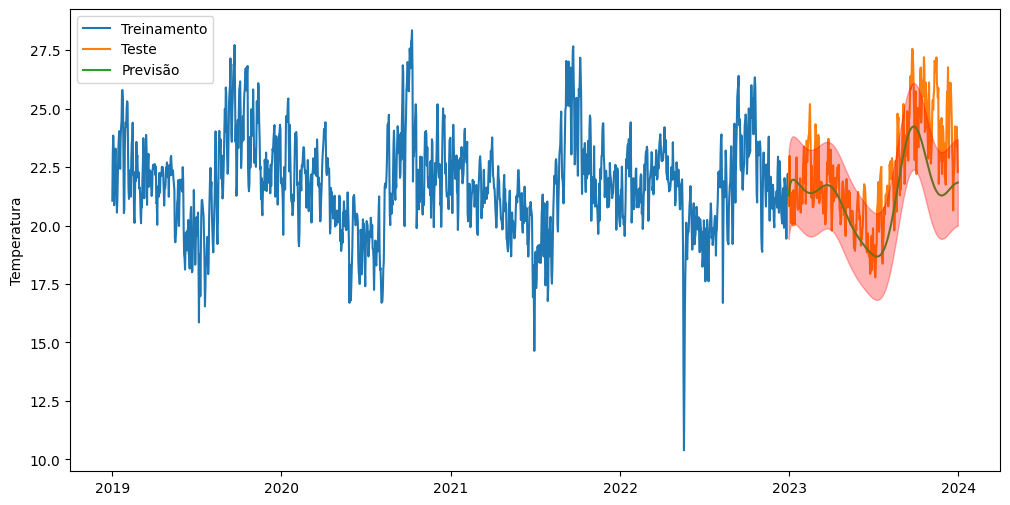

In [6]:
n = len(df_training[forecast_parameter])  # Number of data points
t = np.arange(n)
seasonality = 365  

# Create Fourier terms
def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

num_fourier_terms = 4
fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

# Fit the ARIMA model using arima with Fourier terms as exogenous variables
model = ARIMA(df_training[forecast_parameter],exog=fourier_terms[:n], order=(1,0,0), trend='ct')
model_fit = model.fit()

# Forecast future values with the fitted model
forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test_point_data)), seasonality, num_fourier_terms)

# Get the forecast for the future steps with exogenous variables
forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

# Fazer previsões
forecast = model_fit.forecast(steps=len(df_test_point_data), exog=forecast_df)

# Visualização das previsões
plt.figure(figsize=(12,6))
plt.plot(df_training.index, df_training[forecast_parameter], label='Treinamento')
plt.plot(df_test_point_data.index, df_test_point_data[forecast_parameter], label='Teste')
plt.plot(df_test_point_data.index, forecast, label='Previsão')
plt.ylabel('Temperatura')
plt.legend(loc='upper left')

# Cálculo erro quadrático
mse = mean_squared_error(df_test_point_data[forecast_parameter], forecast)
rmse = mse**0.5 
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
plt.fill_between(df_test_point_data.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

In [ ]:
df_test_point_data

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²)
Data,,,,,,,,,,,,,,,,,,
2022-12-31,0.187931,896.329310,896.590517,896.053448,1104.844286,20.839655,17.966379,21.381897,20.256034,18.443966,17.447414,87.206897,81.396552,84.379310,141.147826,3.366087,1.266957,877.948571
2023-01-01,0.043103,895.443966,895.736207,895.216379,1104.844286,22.217241,17.562069,22.837069,21.523276,18.170690,17.007759,80.387931,74.198276,76.982759,108.767241,4.936207,1.987069,1603.504286
2023-01-02,0.383193,894.386555,894.736975,894.088235,1104.844286,22.973950,17.147899,23.688235,22.321008,17.763866,16.536975,75.033613,67.470588,71.386555,120.126050,5.435294,2.210924,1738.766197
2023-01-03,0.532773,894.181513,894.468908,893.863025,1104.844286,20.827731,17.630252,21.439496,20.278992,18.111765,17.137815,85.672269,79.663866,83.000000,207.857143,4.082353,1.549580,1142.455714
2023-01-04,0.015652,894.420870,894.710435,894.151304,1104.844286,21.154783,17.806957,21.798261,20.580870,18.321739,17.338261,85.113043,79.252174,82.295652,245.486957,5.132174,2.068696,1363.725714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.029091,895.848182,896.123636,895.647273,1104.844286,23.965455,17.841818,24.778182,23.116364,18.712727,16.997273,75.772727,66.709091,71.118182,195.781818,4.479091,1.710000,1698.978571
2023-12-28,0.057895,895.275439,895.525439,895.026316,1104.844286,23.392105,18.395614,24.348246,22.487719,19.099123,17.664912,79.377193,70.008772,74.894737,147.508772,4.453509,1.642105,1317.754286
2023-12-29,0.000000,894.816364,895.100909,894.587273,1104.844286,24.212727,18.722727,25.071818,23.359091,19.356364,18.002727,77.272727,68.918182,73.327273,193.072727,4.437273,1.581818,1336.317143
